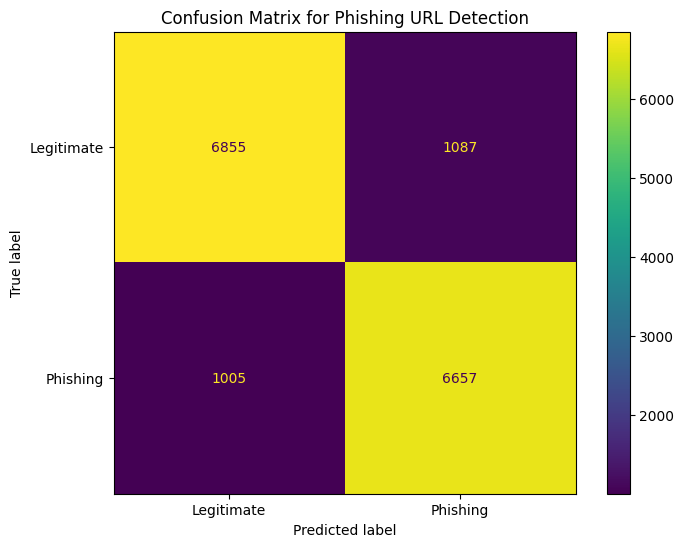

In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load and preprocess the dataset
df = pd.read_csv('url.csv')

# Preprocessing (since there is no null values in it, we can proceed)

df.isnull().sum()

# Scaling 

# since the database is based on the actual counting of the features among the url, we do not need to scale the data.

# splitting data into features and results
df.columns = [''] * len(df.columns)
X = df.iloc[:,:111]
Y = df.iloc[:, -1]


# Training and testing 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

# Fitting the model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, Y_train)

# Prediction

Y_pred = knn_model.predict(X_test)


# Visualization

cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Phishing'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.title('Confusion Matrix for Phishing URL Detection')
plt.show()


filename = 'finalized_model.sav'
pickle.dump(knn_model, open(filename, 'wb'))

In [5]:
import re
from urllib.parse import urlparse
import pandas as pd
import socket
import dns.resolver
import whois
import ssl
import requests
from datetime import datetime
from ipwhois import IPWhois
from bs4 import BeautifulSoup

def count_characters(segment):
    return {
        "qty_dot": segment.count('.'),
        "qty_hyphen": segment.count('-'),
        "qty_underline": segment.count('_'),
        "qty_slash": segment.count('/'),
        "qty_questionmark": segment.count('?'),
        "qty_equal": segment.count('='),
        "qty_at": segment.count('@'),
        "qty_and": segment.count('&'),
        "qty_exclamation": segment.count('!'),
        "qty_space": segment.count(' '),
        "qty_tilde": segment.count('~'),
        "qty_comma": segment.count(','),
        "qty_plus": segment.count('+'),
        "qty_asterisk": segment.count('*'),
        "qty_hashtag": segment.count('#'),
        "qty_dollar": segment.count('$'),
        "qty_percent": segment.count('%')
    }

def check_tld_presence(segment):
    tlds = ['.com', '.net', '.org', '.edu', '.gov', '.uk', '.de', '.jp', '.fr', '.au', '.us', '.ru', '.ch', '.it']
    return any(tld in segment for tld in tlds)

def get_asn_ip(domain):
    try:
        ip = socket.gethostbyname(domain)
        obj = IPWhois(ip)
        res = obj.lookup_whois()
        return res['asn']
    except:
        return -1

def get_dns_records(domain, record_type):
    try:
        answers = dns.resolver.resolve(domain, record_type)
        return len(answers)
    except:
        return 0

def get_ttl(domain):
    try:
        answers = dns.resolver.resolve(domain)
        return answers.rrset.ttl
    except:
        return -1

def get_ssl_certificate(domain):
    context = ssl.create_default_context()
    with socket.create_connection((domain, 443)) as sock:
        with context.wrap_socket(sock, server_hostname=domain) as ssock:
            cert = ssock.getpeercert()
            return cert
    return None

def is_url_google_indexed(url):
  """
  Checks if a URL is likely indexed by Google using a heuristic approach.

  Args:
      url (str): The full URL to check.

  Returns:
      bool: True if the URL is likely indexed, False otherwise.
  """

  user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'  # Example user agent
  headers = {'User-Agent': user_agent}

  # Search for the exact URL (enhanced to potentially handle variations)
  response = requests.get(f"https://www.google.com/search?q={url} OR intitle:{url.split('/')[-1]}", headers=headers)
  soup = BeautifulSoup(response.content, 'html.parser')

  url_indexed = any(
      result.text.strip() == url or url.split('/')[-1] in result.text.strip()  # Check exact match or title match
      for result in soup.find_all('a'))

  return url_indexed

def is_domain_google_indexed(domain):
    """
    Checks if a domain is likely indexed by Google using a heuristic approach.

    Args:
      domain (str): The domain name to check (e.g., "www.example.com").

    Returns:
    bool: True if the domain is likely indexed, False otherwise.
    """
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36'  # Example user agent
    headers = {'User-Agent': user_agent}

  # Search for the domain (enhanced to potentially handle subdomains)
    response = requests.get(f"https://www.google.com/search?q=site:{domain} OR site:www.{domain}", headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')

    domain_indexed = any(result.get('href') and domain in result['href'] for result in soup.find_all('a'))

    return domain_indexed

def extract_features(url):
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    path = parsed_url.path
    query = parsed_url.query

    # Check if domain is in IP address format
    domain_in_ip = bool(re.match(r"^\d{1,3}(\.\d{1,3}){3}$", domain))

    # Check if domain contains the keywords "server" or "client"
    server_client_domain = "server" in domain or "client" in domain

    # URL features
    url_features = count_characters(url)
    url_features.update({
        "qty_tld_url": len(parsed_url.hostname.split('.')[-1]) if parsed_url.hostname else 0,
        "length_url": len(url)
    })
    url_features = {f"{k}_url": v for k, v in url_features.items()}

    # Domain features
    domain_features = count_characters(domain)
    domain_features.update({
        "qty_vowels_domain": sum(1 for char in domain if char in 'aeiouAEIOU'),
        "domain_length": len(domain),
        "domain_in_ip": domain_in_ip,
        "server_client_domain": server_client_domain
    })
    domain_features = {f"{k}_domain": v for k, v in domain_features.items()}

    # Directory and File components
    if '/' in path:
        directory, file = path.rsplit('/', 1)
    else:
        directory, file = path, ''

    directory_features = count_characters(directory)
    directory_features["directory_length"] = len(directory)
    directory_features = {f"qty_{k}_directory": v for k, v in directory_features.items()}

    file_features = count_characters(file)
    file_features["file_length"] = len(file)
    file_features = {f"qty_{k}_file": v for k, v in file_features.items()}

    # Query Parameters
    params_features = count_characters(query)
    params_features.update({
        "params_length": len(query),
        "tld_present_params": check_tld_presence(query),
        "qty_params": query.count('&') + 1 if query else 0
    })
    params_features = {f"{k}_params": v for k, v in params_features.items()}

    # Email detection in URL
    email_in_url = bool(re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b', url))

    # External features
    try:
        whois_info = whois.whois(domain)
        creation_date = whois_info.creation_date[0] if isinstance(whois_info.creation_date, list) else whois_info.creation_date
        expiration_date = whois_info.expiration_date[0] if isinstance(whois_info.expiration_date, list) else whois_info.expiration_date
        days_since_creation = (datetime.now() - creation_date).days if creation_date else -1
        days_until_expiration = (expiration_date - datetime.now()).days if expiration_date else -1
    except:
        days_since_creation = -1
        days_until_expiration = -1

    ssl_cert = get_ssl_certificate(domain)
    ssl_valid = ssl_cert is not None

    external_features = {
        "time_response": requests.get(url).elapsed.total_seconds(),
        "domain_spf": get_dns_records(domain, 'TXT'),
        "asn_ip": get_asn_ip(domain),
        "time_domain_activation": days_since_creation,
        "time_domain_expiration": days_until_expiration,
        "qty_ip_resolved": get_dns_records(domain, 'A'),
        "qty_nameservers": get_dns_records(domain, 'NS'),
        "qty_mx_servers": get_dns_records(domain, 'MX'),
        "ttl_hostname": get_ttl(domain),
        "tls_ssl_certificate": ssl_valid,
        "qty_redirects": len(requests.get(url).history),
        "url_google_index": is_url_google_indexed(url),
        "domain_google_index": is_domain_google_indexed(domain),
        "url_shortened": len(url) < 20
    }

    features = {
        **url_features,
        **domain_features,
        **directory_features,
        **file_features,
        **params_features,
        "email_in_url": email_in_url,
        **external_features
    }

    return features

# Example URL
url = "https://www.youtube.com/"
try:
    # Extract features
    features = extract_features(url)
    # Convert features to DataFrame
    df_features = pd.DataFrame([features])

    df_features.columns = [''] * len(df_features.columns)

    # Replace True with 1 and False with 0
    pd.set_option('future.no_silent_downcasting', True)

# Perform your replace operation
    df_features = df_features.replace({True: 1, False: 0})
    output = knn_model.predict(df_features)
    if output==[0]:
        print("url is legitmate")
    else:
        print("url is phishing")
except:
    print("url is phishing")

url is legitmate
